## Loading the dataset
### Imports

In [55]:
from pathlib import Path

import keras.optimizers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input

### Convert filename to useful metadata

In [56]:
def filename_to_metadata(file_names: list[str], file_extension: str, only_labels=False):
    """
    Gets dataset type, fold, source name, label and take from .wav filename.

    :param file_names: List of .wav filename strings
    :param file_extension: The file extension (e.g. .wav).
    :param only_labels: Bool, where True means returning only a list of labels.
    :return: List of dictionaries ["dataset_type", "fold", "source_name", "label", "take"] or strings.
    """
    # stft-1-137-A-32.wav
    # stft --> Dataset type
    # 1 --> Fold
    # 137 --> Source name
    # A --> Take
    # 32 --> Label

    metadata_list = []

    for filename in file_names:
        filename = filename.replace(file_extension, "")
        dataset_type, fold, source_name, take, label = re.split(r"-", filename)

        data_dict = {"dataset_type": dataset_type, "fold": int(fold), "source_name": source_name, "take": take,
                     "label": int(label)}

        if only_labels:
            metadata_list.append(data_dict["label"])
        else:
            metadata_list.append(data_dict)

    return metadata_list

In [57]:
def filepath_to_img_data(path_to_dir: Path, filenames: list[str], resize_shape: tuple[int, int] = None):
    """
    Takes the path to images to create data objects.

    :param path_to_dir: Path object of the path to the data directory.
    :param filenames: List of filenames.
    :param resize_shape: The new dimensions of the images.
    :return:
    """
    img_data = []

    for filename in filenames:
        path_to_img = path_to_dir / filename

        base_img = cv2.imread(str(path_to_img))
        final_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

        if resize_shape is not None:
            final_img = cv2.resize(final_img, resize_shape)

        img_data.append(final_img)

    return img_data

### Relative paths

In [58]:
path_to_data = Path.cwd() / ".." / "data"

path_to_waveform = path_to_data / "waveform"
path_to_stft = path_to_data / "STFT"
path_to_mel = path_to_data / "mel"

### Filenames of all images

In [59]:
waveform_filenames = [file.name for file in path_to_waveform.glob("*.png")]
stft_filenames = [file.name for file in path_to_stft.glob("*.png")]
mel_filenames = [file.name for file in path_to_mel.glob("*.png")]

### Load images as dataset X and y
* Optional resizing of image

In [60]:
image_resize = (512, 512)

wav_X = filepath_to_img_data(path_to_waveform, waveform_filenames, resize_shape=image_resize)
wav_y = filename_to_metadata(waveform_filenames, ".png", only_labels=True)

stft_X = filepath_to_img_data(path_to_stft, stft_filenames, resize_shape=image_resize)
stft_y = filename_to_metadata(stft_filenames, ".png", only_labels=True)

mel_X = filepath_to_img_data(path_to_mel, mel_filenames, resize_shape=image_resize)
mel_y = filename_to_metadata(mel_filenames, ".png", only_labels=True)

### Train/test split

In [61]:
def split_and_nparray(X_set, y_set, _train_size, _rng):
    X_train, X_test, y_train, y_test = train_test_split(
        X_set, y_set, train_size=_train_size, random_state=_rng
    )

    return map(np.array, (X_train, X_test, y_train, y_test))


train_size = 0.9
rng = 42

wav_X_train, wav_X_test, wav_y_train, wav_y_test = split_and_nparray(wav_X, wav_y, train_size, rng)
stft_X_train, stft_X_test, stft_y_train, stft_y_test = split_and_nparray(stft_X, stft_y, train_size, rng)
mel_X_train, mel_X_test, mel_y_train, mel_y_test = split_and_nparray(mel_X, mel_y, train_size, rng)

## Defining the CNN model

### Parameters:
* Classes = 50
* Channels = 3
* Kernel size
* Padding
* Stride
* Dilation

### Layers:
* Pooling (max pooling and average pooling)
* Strided conv
* Normalization
* Activation (ReLU)
* Conv --> Normalization --> Activation

### Dense:
* Regular NN

In [78]:
def cnn_model(_input_shape, _num_classes):
    # Parameters
    lr = 1e-3
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.SparseCategoricalCrossentropy()
    metrics = ["accuracy"]
    act_func = "relu"
    k_size = 8
    p_size = (4, 4)  # (Height, width)

    # Model definition
    model = models.Sequential()

    # Convolution layers
    model.add(layers.InputLayer(_input_shape))
    model.add(layers.Conv2D(filters=32, kernel_size=k_size, activation=act_func, padding="same"))
    model.add(layers.MaxPooling2D(p_size))
    model.add(layers.Conv2D(filters=64, kernel_size=k_size, activation=act_func, padding="same"))
    model.add(layers.MaxPooling2D(p_size))
    model.add(layers.Conv2D(filters=64, kernel_size=k_size, activation=act_func, padding="same"))
    model.add(layers.MaxPooling2D(p_size))

    # Flattening and dense layer input
    num_pool = 3 # Change this to the amount pooling layers above
    dense_input = np.prod((_input_shape[0] / (p_size[0] ** num_pool), _input_shape[1] / (p_size[1] ** num_pool)))
    dense_input *= 3

    # Dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(int(dense_input), activation=act_func))
    model.add(layers.Dense(_num_classes))

    # Compile and summary
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=metrics
    )

    model.summary()

    return model

### Input parameters for model

In [79]:
num_train_samples = wav_X_train.shape[0]
img_size = wav_X_train.shape[1:-1]
num_channels = wav_X_train.shape[-1]
num_classes = 50
input_shape = wav_X_train.shape[1:]

print(f"Image size (width x height): {img_size[1]} x {img_size[0]}")
print(f"Input shape: ({input_shape})")

Image size (width x height): 512 x 512
Input shape: ((512, 512, 3))


In [80]:
basic_model = cnn_model(_input_shape=input_shape, _num_classes=num_classes)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 512, 512, 32)   │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 192)            │       786,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         9,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,195,794 (4.56 MB)

 Trainable params: 1,195,794 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [81]:
num_epochs = 10
batch_size = 32
validation_split = 0.1

history = basic_model.fit(wav_X_train, wav_y_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_split=validation_split)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.0191 - loss: 11.9621 - val_accuracy: 0.0000e+00 - val_loss: 11.7769
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.0204 - loss: 12.0740 - val_accuracy: 0.0000e+00 - val_loss: 11.7764
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.0204 - loss: 12.0739 - val_accuracy: 0.0000e+00 - val_loss: 11.7764
Epoch 4/10
44/51 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.0196 - loss: 11.7706

KeyboardInterrupt: 

## Testing the model

7/7 - 1s - 182ms/step - accuracy: 0.0300 - loss: 12.8836
0.029999999329447746


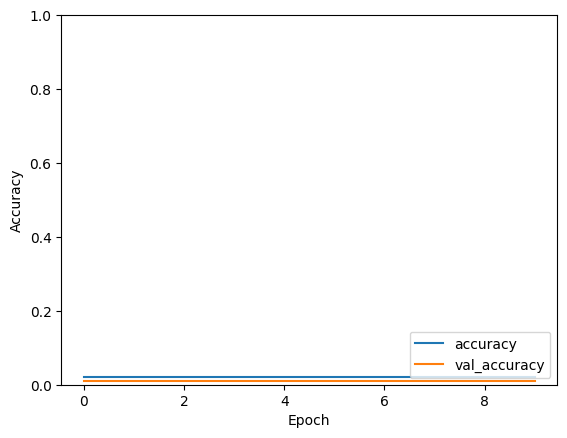

In [76]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = basic_model.evaluate(wav_X_test, wav_y_test, verbose=2)
print(test_acc)